#Priyanshu Singh 170101049 Assignment 2

In [ ]:
import requests
import nltk
nltk.download('punkt')
from IPython.display import display, Markdown
import random, more_itertools
! pip install sparse
from scipy import sparse
import numpy as np

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


##``Downloading the corpus``

In [ ]:
!wget https://www.dropbox.com/s/1agrh5hdnkqd24c/en_wiki.txt?dl=0        # downloads the dataset
!mv en_wiki.txt?dl=0 en_data.txt

with open("en_data.txt", "r") as file1:         # reading the data file
    en_text = file1.read()
en_text = en_text.replace('\n', '')

--2020-11-05 17:22:14--  https://www.dropbox.com/s/1agrh5hdnkqd24c/en_wiki.txt?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.1, 2620:100:601d:1::a27d:501
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/1agrh5hdnkqd24c/en_wiki.txt [following]
--2020-11-05 17:22:15--  https://www.dropbox.com/s/raw/1agrh5hdnkqd24c/en_wiki.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca3d5dd66e4807ef2cf5b6145c5.dl.dropboxusercontent.com/cd/0/inline/BCovwoduYGjzx6DSqJTP-E1e8jBu2AX1M0rPB15J16x4L2KS-hbdPtoy86guu-BO3u6xna0mEtu7p8k-WKy_LVLS5ETqYWWRGafFRj3ESJf6OHLMm--GxIApE873nvWYijk/file# [following]
--2020-11-05 17:22:15--  https://uca3d5dd66e4807ef2cf5b6145c5.dl.dropboxusercontent.com/cd/0/inline/BCovwoduYGjzx6DSqJTP-E1e8jBu2AX1M0rPB15J16x4L2KS-hbdPtoy86guu-BO3u6xna0mEtu7p8k-WKy_LVLS5ETqYWWRGafFRj3ESJf6OHLM

##``Building Vocab and Co-occurence matrix``

In [ ]:
from collections import Counter, defaultdict

# Returns a dictionary `w -> freq`, mapping word strings to word corpus frequency.
def build_vocab(tokens_en):
    vocab = {}
    for token in tokens_en:
        vocab[token] = vocab.get(token, 0) + 1

    return vocab

# Build a word co-occurrence list for the given corpus as described in Pennington et al.(2014)
def build_cooccur(vocab, tokens_en, window_size):
    cooccurence_matrix = defaultdict(lambda: 0)
    vocab_size = len(vocab)

    for i, word in enumerate(tokens_en):
      for j in range(max(0, i - window_size), min(len(tokens_en), i + window_size + 1)):
        if j != i and word in vocab and tokens_en[j] in vocab:
          cooccurence_matrix[word, tokens_en[j]] = cooccurence_matrix.get((tokens_en[i], tokens_en[j]), 0) + 1

    return cooccurence_matrix

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
import random
nltk.download('punkt')  # in order to make "nltk.tokenize.word_tokenize" work

tokens_en = word_tokenize(en_text)
vocab = build_vocab(tokens_en)              
sorted_vocab = sorted(vocab.items(), key = lambda kv:(kv[1], kv[0]), reverse = True)
sorted_vocab = sorted_vocab[:min(10000, len(sorted_vocab))]                 # limits the vocab to a size of 10,000
vocab = {word[0] : word[1] for word in sorted_vocab}
cooccurence_matrix = build_cooccur(vocab, tokens_en, window_size = 4)       # window size can be adjusted, taken as 4 here
print("Length of Vocab is :", len(vocab))
print("Length of cooccurence_matrix is :", len(cooccurence_matrix))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Length of Vocab is : 10000
Length of cooccurence_matrix is : 10673658


##``Gradient Descent``

In [ ]:
import numpy as np

# function f(x) which is used to calculate cost
def f(x, x_max, alpha):
  if x < x_max:
    return (x / x_max) ** alpha
  else:
    return 1

# does one step of the gradient descent algorithm
def CostUpd_iter(vocab, cooccurence_matrix, W_center, U_context, bias_center, bias_context, learning_rate, x_max, alpha):
  
  # initialize the gradient vectors and cost by 0
  cost = 0
  dW_center = np.zeros(W_center.shape, dtype = "float64")
  dU_context = np.zeros(U_context.shape, dtype = "float64")
  dbias_center = np.zeros(bias_center.shape, dtype = "float64")
  dbias_context = np.zeros(bias_context.shape, dtype = "float64")

  # for every main word, all the words from vocab are considered for calculation of gradients
  # refer to report for mathematical derivations of these derivatives
  for i, word1 in enumerate(vocab.keys()):
    for j, word2 in enumerate(vocab.keys()):
      x = cooccurence_matrix.get((word1, word2), 0)
      f_x_ij = f(x, x_max, alpha)
      gradient1 = 0
      gradient2 = 0

      if x > 0:
        gradient1 = np.dot(W_center[i], U_context[j]) + bias_center[i] + bias_context[j] - np.log(x)
        gradient2 = np.dot(W_center[j], U_context[i]) + bias_center[j] + bias_context[i] - np.log(x)
        cost += f_x_ij * gradient1 * gradient1

      dW_center[i] += 2 * f_x_ij * gradient1 * U_context[j]
      dbias_center[i] += 2 * f_x_ij * gradient1
      dU_context[i] += 2 * f_x_ij * gradient2 * W_center[j]
      dbias_context[i] += 2 * f_x_ij * gradient2

  # update the gradient vectors (W -> W - α * dW)
  W_center = W_center - learning_rate * dW_center
  bias_center = bias_center - learning_rate * dbias_center
  U_context = U_context - learning_rate * dU_context
  bias_context = bias_context - learning_rate * dbias_context

  return cost, W_center, U_context, bias_center, bias_context

##``Training the model``

In [ ]:
# main function which is called for training the corpus to calculate word embeddings
def train_glove(vocab, cooccurence_matrix, vector_size, iterations, alpha, x_max, learning_rate):
    vocab_size = len(vocab)

    # Initialize 2 random word vector matrices in range (-0.5, 0.5] for each token,
    # one for the token as (main) center and one for the token as context 
    W_center = (np.random.rand(vocab_size, vector_size))
    U_context = (np.random.rand(vocab_size, vector_size))

    # Bias terms, each associated with a single vector.
    bias_center = (np.random.rand(vocab_size))
    bias_context = (np.random.rand(vocab_size))

    total_cost = 0

    # prints the cost after each epoch of the training set, learning rate should be such that cost decrease
    for i in range(iterations):
      cost, W_center, U_context, bias_center, bias_context = CostUpd_iter(vocab, cooccurence_matrix, W_center, U_context, bias_center, bias_context, learning_rate, x_max, alpha)
      print("Cost after Iteration ", i)
      print(" =", cost)
      total_cost = cost

    return W_center, U_context, bias_center, bias_context, total_cost, iterations

In [ ]:
# calling the train function which returns us the different lists which contain main and context word embeddings
# hyperparameters for the whole model is passed in the arguments of the train function

# This piece of code runs for 4-5 hours
W_center, U_context, bias_center, bias_context, total_cost, iterations = train_glove(vocab, cooccurence_matrix, vector_size = 100, iterations = 35, alpha = 0.75, x_max = 100, learning_rate = 0.000001)

In [ ]:
# storing the word embeddings in a dictionary
import random
emb = {}
for i, word in enumerate(vocab.keys()):
  emb[word] = W_center[i]

##``Downloading pre-trained word embeddings``

In [ ]:
# downloads the pre-trained word embeddings
!gdown --id 1-1-P_FT9eziKTjYucRLPU7GOdt-Jle3b
# getting benchmark dataset Word Similarity 353
!wget http://alfonseca.org/pubs/ws353simrel.tar.gz
!tar -xvzf ws353simrel.tar.gz

Downloading...
From: https://drive.google.com/uc?id=1-1-P_FT9eziKTjYucRLPU7GOdt-Jle3b
To: /content/drive/My Drive/glove.6B.100d.txt
347MB [00:03, 89.8MB/s]
--2020-11-05 18:14:26--  http://alfonseca.org/pubs/ws353simrel.tar.gz
Resolving alfonseca.org (alfonseca.org)... 162.215.249.67
Connecting to alfonseca.org (alfonseca.org)|162.215.249.67|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5460 (5.3K) [application/x-gzip]
Saving to: ‘ws353simrel.tar.gz.1’

ws353simrel.tar.gz. 100%[===================>]   5.33K  --.-KB/s    in 0s      

2020-11-05 18:14:27 (349 MB/s) - ‘ws353simrel.tar.gz.1’ saved [5460/5460]

wordsim353_sim_rel/wordsim353_agreed.txt
wordsim353_sim_rel/wordsim353_annotator1.txt
wordsim353_sim_rel/wordsim353_annotator2.txt
wordsim353_sim_rel/wordsim_relatedness_goldstandard.txt
wordsim353_sim_rel/wordsim_similarity_goldstandard.txt


In [ ]:
# get a dictionary containing pre-trained embeddings from the downloaded text file
def extract_pretrained_word_emb():
  with open("glove.6B.100d.txt", "r") as f:
    words = f.readlines()

  words = [line.replace('\n','') for line in words]
  pre_trained_word_embeddings = {}

  for line in words:
    words = line.split()
    vec = np.random.rand(100)
    for i in range(1,101):
      vec[i-1] = float(words[i])
    pre_trained_word_embeddings[words[0]] = vec

  return pre_trained_word_embeddings

pre_trained_word_embeddings = extract_pretrained_word_emb()

In [ ]:
# calculate word similarity between two words using the given embeddings
from scipy import spatial

def check_word_similarity(word1, word2, emb):
  return 1 - spatial.distance.cosine(emb[word1], emb[word2])

##``Calculating word similarity``



In [ ]:
# compares pre-trained word embedding and the trained word embedding by calculating cosine similarity

with open("wordsim353_sim_rel/wordsim_similarity_goldstandard.txt", "r") as f:
  lines = f.readlines()

lines = [line.replace('\n', '') for line in lines]

word_pairs = [] # pairs of words from Word Similarity 353 dataset
new_trained = [] # cosine similarity values using the trained model
pre_trained = [] # cosine similarity values using pre-trained model

for line in lines:
  words = line.split()

  if words[0] in emb.keys() and words[1] in emb.keys():
    if words[0] in pre_trained_word_embeddings.keys() and words[1] in pre_trained_word_embeddings.keys():
      word_pairs.append(words[0] + '_' + words[1])
      new_trained.append(check_word_similarity(words[0], words[1], emb))
      pre_trained.append(check_word_similarity(words[0], words[1], pre_trained_word_embeddings))
      print(words[0], words[1], check_word_similarity(words[0], words[1], emb), check_word_similarity(words[0], words[1], pre_trained_word_embeddings))

plane car 0.03652390921143678 0.5961414305939505
train car -0.027899742203035593 0.6822721999622072
television radio 0.019535632567166616 0.8153580525333616
media radio -0.004458064463829459 0.6588770837986025
professor doctor -0.043007807688403066 0.5301827662460379
student professor -0.009489226522699346 0.5851861425494358
wood forest -0.02164947912503168 0.5236123063734079
money cash 0.06615825993050928 0.8484836278805994
king queen 0.18758836773267973 0.7507690793623848
football soccer 0.16130101806052966 0.8732220727047814
football basketball 0.1232395084968545 0.85556370472903
football tennis -0.10262296219914546 0.5885030585761516
physics chemistry 0.06537303908895964 0.8498000474285736
drink eat -0.10139405018908176 0.6849385420942607
car automobile 0.05258791305225008 0.6831941855554005
journey voyage -0.09175079195765834 0.7682994212640839
coast shore 0.09749992180861988 0.7000271785427719
food fruit 0.03048974268029725 0.573560323492919
money dollar -0.02968196370992726 0.54

##``Plot``

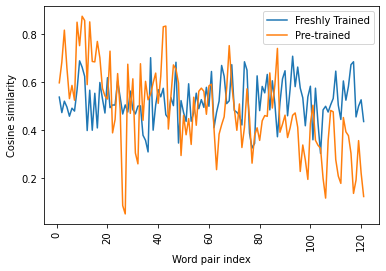

In [ ]:
# plotting the values to see the difference between my and pre-trained models 

import matplotlib.pyplot as plt

indexes = [i + 1 for i in range(len(word_pairs))]

plt.plot(indexes, new_trained, label = 'Freshly Trained')
plt.plot(indexes, pre_trained, label = 'Pre-trained')
plt.legend()
plt.xlabel('Word pair index')
plt.ylabel('Cosine similarity')
plt.xticks(rotation=90)
plt.show()